In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset

from sklearn import metrics
import myfm
plt.style.use('ggplot')

# Data exploration 

## New Movielens-100k

In [ ]:
data_path = "ml-latest-small/"
df_rating = pd.read_csv(f"{data_path}ratings.csv")
df_rating

In [ ]:
sparsity = 1 - len(df_rating) / (df_rating['movieId'].unique().shape[0] * df_rating['userId'].unique().shape[0])
print(f"sparsity: {sparsity:.4%}")
df_rating

sparsity: 98.3000%


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Distribution of Ratings

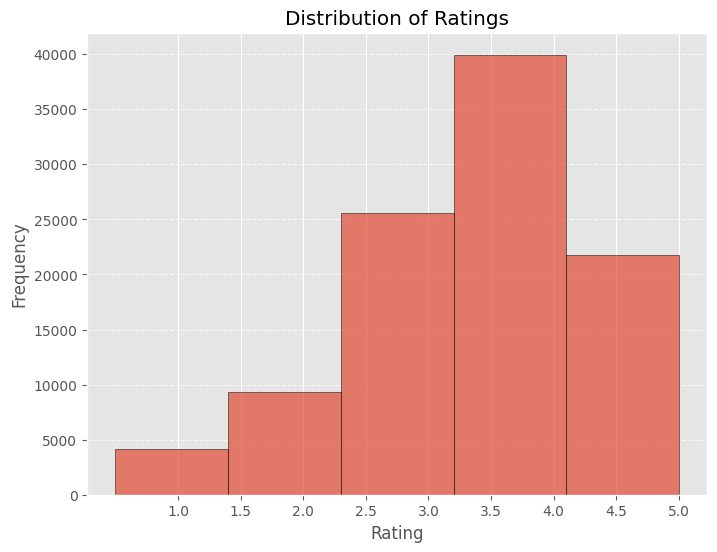

In [8]:
# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_rating['rating'], bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Distribution of Ratings per movie/user

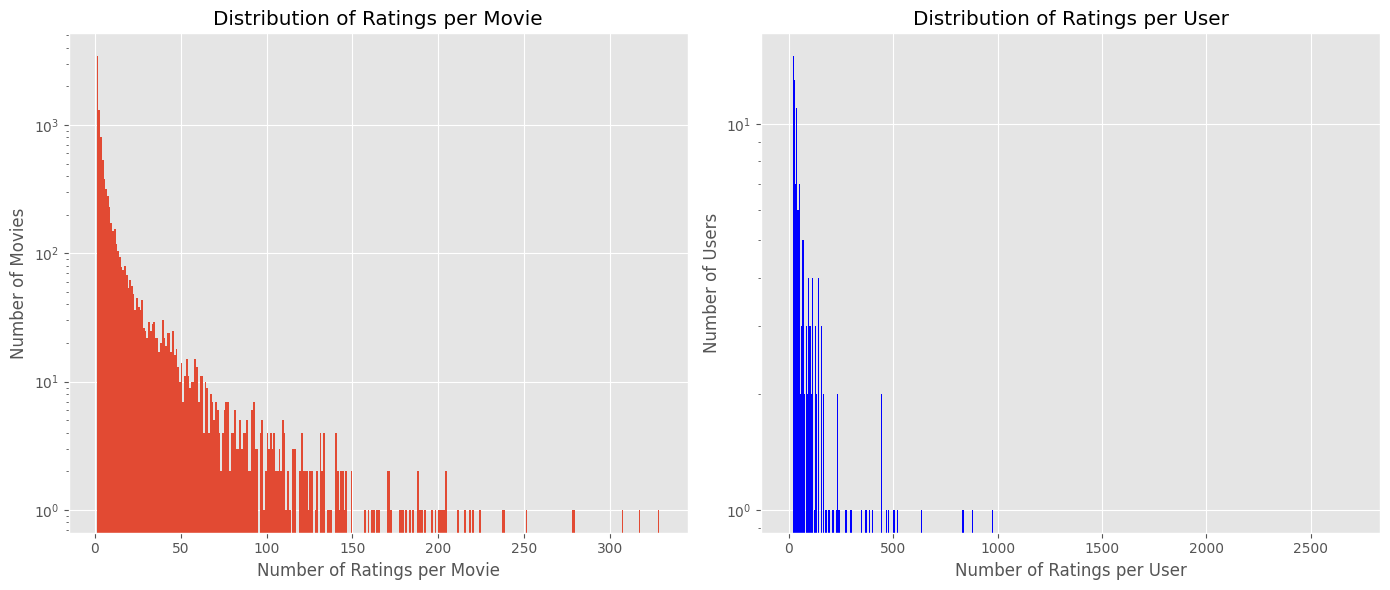

In [9]:
rating_count = df_rating['movieId'].value_counts()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(rating_count, bins=range(1, rating_count.max() + 1), log=True)
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings per Movie')
plt.grid(True)

user_rating_count = df_rating['userId'].value_counts()
plt.subplot(1, 2, 2)
plt.hist(user_rating_count, bins=range(1, user_rating_count.max() + 1), log=True, color="blue")
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Ratings per User')
plt.grid(True)
plt.tight_layout()
plt.show()

### Additional metadata

In [71]:
df_movie = pd.read_csv(f"{data_path}movies.csv")
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [72]:
df_movie['release_year'] = df_movie['title'].str.extract(r'\((\d{4})\)')
df_movie['title'] = df_movie['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True)
df_movie['release_year'] = df_movie['release_year'].astype(str)
print(df_movie['release_year'].isnull().sum())
df_movie

0


,movieId,title,genres,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018


In [ ]:
df_tag = pd.read_csv(f"{data_path}tags.csv")
df_tag

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [26]:
df_link = pd.read_csv(f"{data_path}links.csv")
df_link

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


# Recommender System Model

## Pure Collaborative Filtering (No extra metadata)

In [13]:
from surprise import BaselineOnly, KNNBasic, KNNWithMeans, KNNBaseline, SVD, SVDpp, NMF, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader

# Load movielens-100k dataset
reader = Reader()
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

# List of algorithms to test
algorithms = [
    BaselineOnly(),
    KNNBasic(),
    KNNWithMeans(),
    KNNBaseline(),
    SVD(),
    SVDpp(),
    NMF(),
    SlopeOne(),
    CoClustering()
]

algo_names = [
    "BaselineOnly", "KNNBasic", "KNNWithMeans", "KNNBaseline",
    "SVD", "SVDpp", "NMF", "SlopeOne", "CoClustering"
]

# Dictionary to store results
results = {}

# Run cross-validation for each algorithm
for algo, name in zip(algorithms, algo_names):
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    results[name] = {
        "RMSE": np.mean(cv_results["test_rmse"]),
        "MAE": np.mean(cv_results["test_mae"])
    }

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating 

In [79]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.sparse as sps

FM_RANK = 10

# Split data (80% train, 20% test)
df_train, df_test = train_test_split(df_rating, test_size=0.2, random_state=42)

FEATURE_COLUMNS = ['userId', 'movieId']
ohe = OneHotEncoder(handle_unknown='ignore')

movie_info = df_movie.set_index('movieId')[['release_year', 'genres']]
movie_info_ohe = OneHotEncoder(handle_unknown='ignore').fit(movie_info[['release_year']])
movie_genre_mle = MultiLabelBinarizer(sparse_output=True).fit(
    movie_info.genres.apply(lambda x: x.split('|'))
)

X_train = ohe.fit_transform(df_train[FEATURE_COLUMNS])
X_test = ohe.transform(df_test[FEATURE_COLUMNS])
y_train = df_train.rating.values
y_test = df_test.rating.values

X_train_extended = sps.hstack([
    X_train,
    movie_info_ohe.transform(
        movie_info.reindex(df_train.movieId).drop(columns=['genres'])
    ),
    movie_genre_mle.transform(
        movie_info.genres.reindex(df_train.movieId).apply(lambda x: x.split('|'))
    )
])

X_test_extended = sps.hstack([
    X_test,
    movie_info_ohe.transform(
        movie_info.reindex(df_test.movieId).drop(columns=['genres'])
    ),
    movie_genre_mle.transform(
        movie_info.genres.reindex(df_test.movieId).apply(lambda x: x.split('|'))
    )
])


group_shapes_extended = (
    [len(group) for group in ohe.categories_] +
    [len(group) for group in movie_info_ohe.categories_] +
    [ len(movie_genre_mle.classes_)]
)

fm_side_info = myfm.MyFMRegressor(
    rank=FM_RANK, random_seed=42,
)
fm_side_info.fit(
    X_train_extended, y_train, n_iter=200, n_kept_samples=200,
    group_shapes=group_shapes_extended
)

prediction_side_info = fm_side_info.predict(X_test_extended)
rmse = ((y_test - prediction_side_info) ** 2).mean() ** .5
mae = np.abs(y_test - prediction_side_info).mean()
print(f'rmse={rmse}, mae={mae}')
results["BFM"] = {
        "RMSE": rmse,
        "MAE": mae,
    }

alpha = 2.28 w0 = 3.51 : 100%|██████████| 200/200 [00:11<00:00, 17.50it/s]


rmse=0.8178972217499246, mae=0.6241864680968413


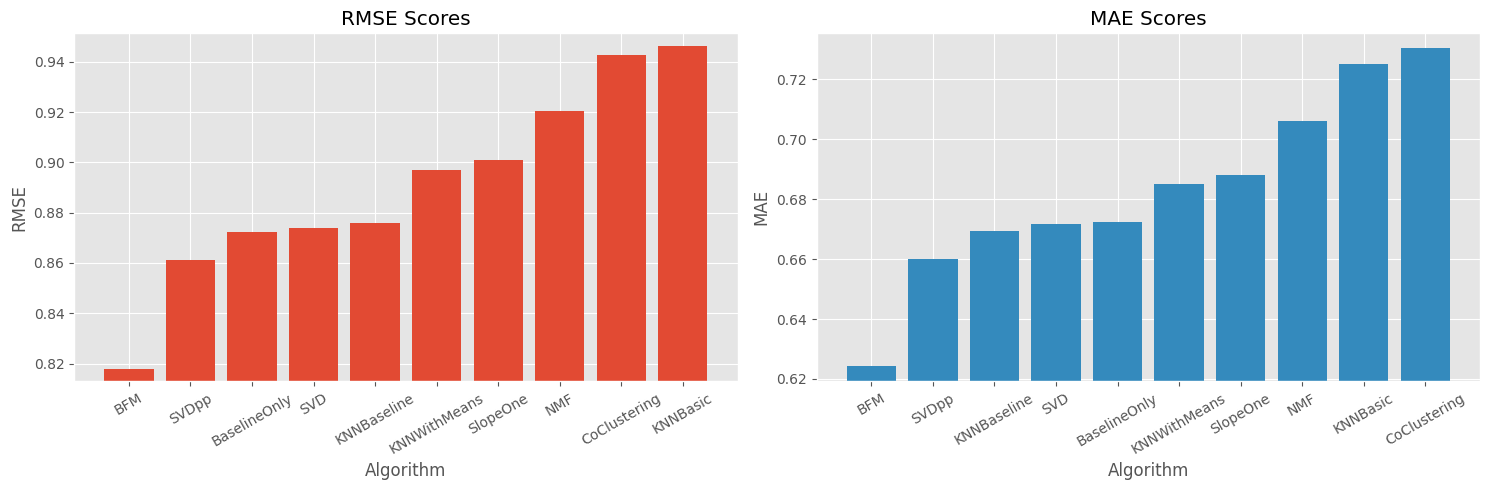

{'BaselineOnly': {'RMSE': 0.8723673840547951, 'MAE': 0.6724626286142912},
 'KNNBasic': {'RMSE': 0.9463113917471404, 'MAE': 0.7252894791135777},
 'KNNWithMeans': {'RMSE': 0.8968433325341566, 'MAE': 0.6850229461551064},
 'KNNBaseline': {'RMSE': 0.876035949347029, 'MAE': 0.6693080762497112},
 'SVD': {'RMSE': 0.8737051465018955, 'MAE': 0.6717194975283495},
 'SVDpp': {'RMSE': 0.8611469066101674, 'MAE': 0.6599117850353037},
 'NMF': {'RMSE': 0.9203376410758691, 'MAE': 0.7059546673007997},
 'SlopeOne': {'RMSE': 0.9010838395980016, 'MAE': 0.6880431766869805},
 'CoClustering': {'RMSE': 0.9427913143478606, 'MAE': 0.7303876148442647},
 'BFM': {'RMSE': 0.8178972217499246, 'MAE': 0.6241864680968413}}

In [80]:
algo_names = [
    "BaselineOnly", "KNNBasic", "KNNWithMeans", "KNNBaseline",
    "SVD", "SVDpp", "NMF", "SlopeOne", "CoClustering", "BFM"
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)

# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("RMSE Scores")
ax1.set_xlabel("Algorithm")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("MAE Scores")
ax2.set_xlabel("Algorithm")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.show()
results